In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import shap


# 2. Load the HR Dataset

In [3]:

file_path = r"D:\for internship\HR_Analytics (1).csv"
df = pd.read_csv(file_path)
df.head()


,EmpID,Age,AgeGroup,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,RM297,18,18-25,Yes,Travel_Rarely,230,Research & Development,3,3,Life Sciences,...,3,80,0,0,2,3,0,0,0,0.0
1,RM302,18,18-25,No,Travel_Rarely,812,Sales,10,3,Medical,...,1,80,0,0,2,3,0,0,0,0.0
2,RM458,18,18-25,Yes,Travel_Frequently,1306,Sales,5,3,Marketing,...,4,80,0,0,3,3,0,0,0,0.0
3,RM728,18,18-25,No,Non-Travel,287,Research & Development,5,2,Life Sciences,...,4,80,0,0,2,3,0,0,0,0.0
4,RM829,18,18-25,Yes,Non-Travel,247,Research & Development,8,1,Medical,...,4,80,0,0,0,3,0,0,0,0.0


# 3. Initial Data Exploration

In [4]:

print(df.info())
print(df.describe())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmpID                     1480 non-null   object 
 1   Age                       1480 non-null   int64  
 2   AgeGroup                  1480 non-null   object 
 3   Attrition                 1480 non-null   object 
 4   BusinessTravel            1480 non-null   object 
 5   DailyRate                 1480 non-null   int64  
 6   Department                1480 non-null   object 
 7   DistanceFromHome          1480 non-null   int64  
 8   Education                 1480 non-null   int64  
 9   EducationField            1480 non-null   object 
 10  EmployeeCount             1480 non-null   int64  
 11  EmployeeNumber            1480 non-null   int64  
 12  EnvironmentSatisfaction   1480 non-null   int64  
 13  Gender                    1480 non-null   object 
 14  HourlyRa

# 4. Exploratory Data Analysis (EDA)

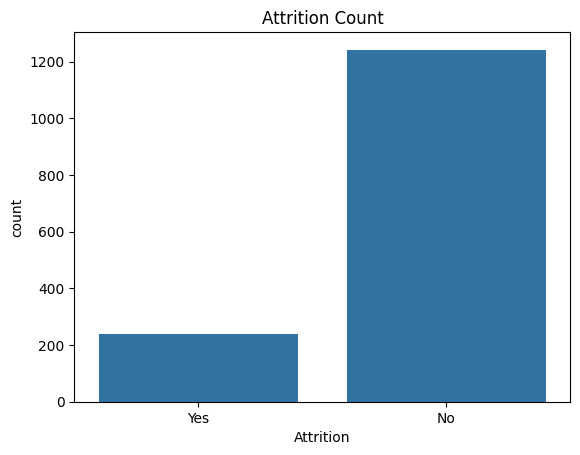

In [5]:
sns.countplot(x='Attrition', data=df)
plt.title("Attrition Count")
plt.show()


# 4.2. Department-wise Attrition

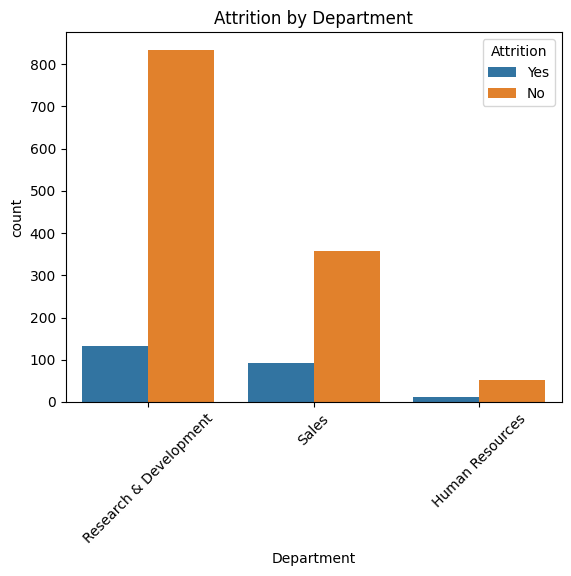

In [6]:
sns.countplot(x='Department', hue='Attrition', data=df)
plt.title("Attrition by Department")
plt.xticks(rotation=45)
plt.show()


# 4.3. Salary vs Attrition

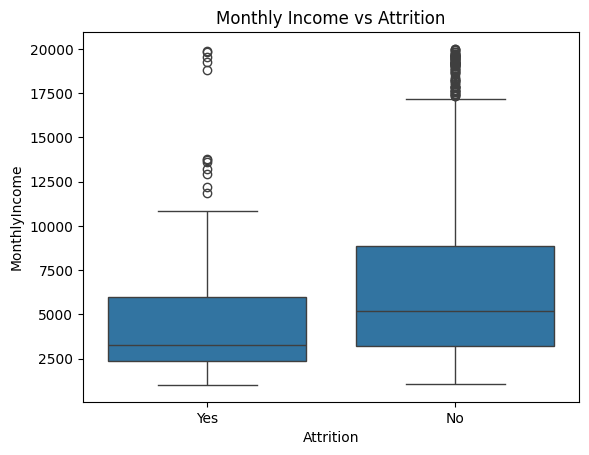

In [7]:
sns.boxplot(x='Attrition', y='MonthlyIncome', data=df)
plt.title("Monthly Income vs Attrition")
plt.show()


# 4.4. Promotions vs Attrition

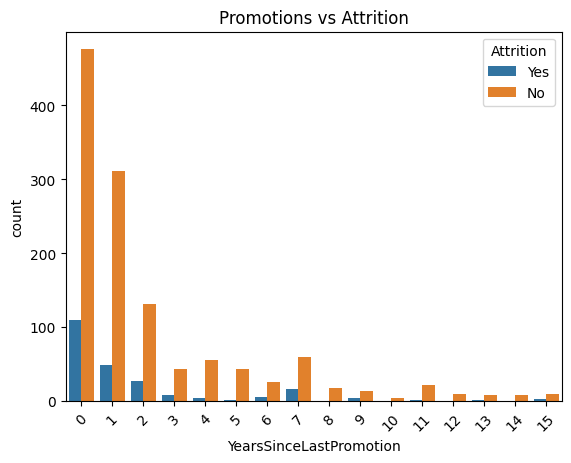

In [8]:
sns.countplot(x='YearsSinceLastPromotion', hue='Attrition', data=df)
plt.title("Promotions vs Attrition")
plt.xticks(rotation=45)
plt.show()


# 5. Data Preprocessing

# 5.1 Drop unnecessary columns

In [12]:
df = df.drop(columns=['EmpID', 'EmployeeNumber', 'Over18', 'StandardHours', 'EmployeeCount'])

# 5.2 Encode Categorical Columns

In [19]:
# Drop rows with missing values
df = df.dropna()
# Get list of object (categorical) columns before encoding
categorical_cols = df.select_dtypes(include='object').columns

# Encode 'Attrition' first
le = LabelEncoder()
df['Attrition'] = le.fit_transform(df['Attrition'])

# Encode remaining categorical columns
df[categorical_cols] = df[categorical_cols].apply(le.fit_transform)

# Drop rows with missing values (NaNs)
df = df.dropna()



# 6. Train-Test Split

In [22]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# Fill missing values with median (good for both numbers and label-encoded categories)
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Now do train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)


# 7. Logistic Regression Model

In [24]:
from sklearn.preprocessing import StandardScaler

# Scale features (improves convergence)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the model with increased max_iter
model = LogisticRegression(max_iter=3000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


# 8: Evaluate Model Accuracy

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Print accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Detailed classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8771929824561403
Confusion Matrix:
 [[234   3]
 [ 32  16]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93       237
           1       0.84      0.33      0.48        48

    accuracy                           0.88       285
   macro avg       0.86      0.66      0.70       285
weighted avg       0.87      0.88      0.85       285



# 9:SHAP for Explainability

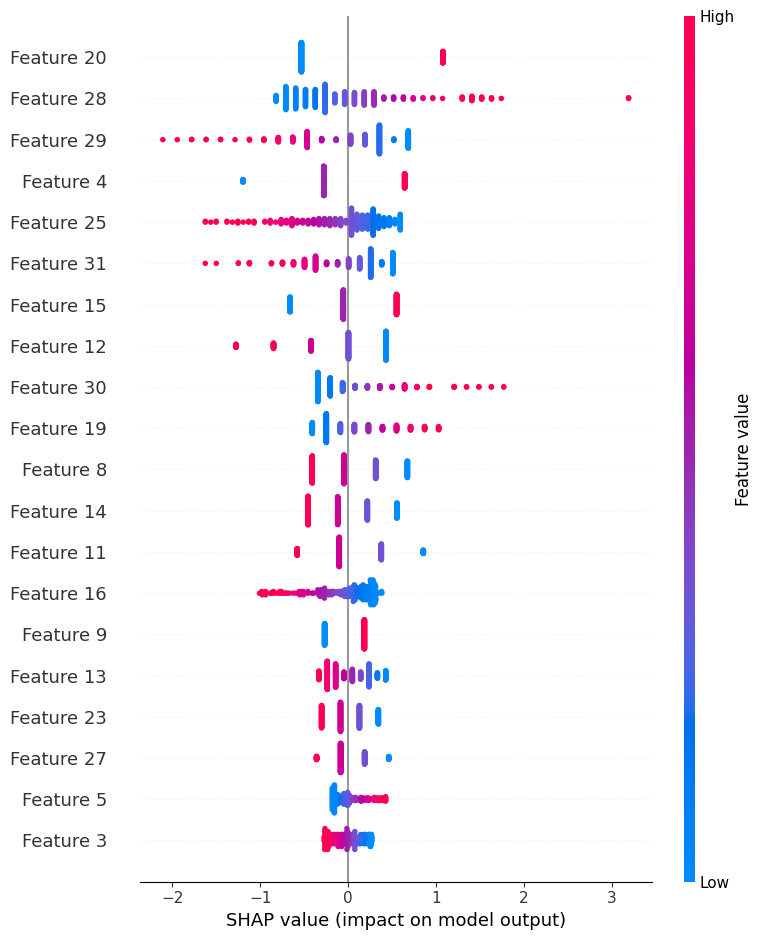

In [26]:
import shap

# Create SHAP explainer and plot feature impact
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Summary plot (may take a few seconds)
shap.summary_plot(shap_values, X_test)


# Step 10: Export Cleaned Data

In [27]:
# Save final dataframe with encoded and cleaned data
df.to_csv("cleaned_HR_data.csv", index=False)
